# Basic Monte Carlo Techniques
## MC of a Lennard-Jones system
In this exercise, we will study a 3D Lennard-Jones NVT system.
A cubic box of volume $V$ encloses $N$ particles at a given temperature $T$
in any configuration allowed by the potential energy $U$.
The potential is defined as
\begin{equation}
 U(r)=\begin{cases}
      4\epsilon \left[\left(\frac{\sigma}{r}\right)^{12}-
      \left(\frac{\sigma}{r}\right)^6\right] &\qquad r\leq r_c\\
      0 &\qquad r> r_c
      \end{cases}
\end{equation}


<div style="text-align: center;padding:30px">
<img src="https://i.postimg.cc/fbpMP4t3/lj.png" width="300"><img src="https://i.postimg.cc/pTP5R2w6/lj-mc-snapshot.png
" width="200">
</div>

The contributions of the particles beyond this cutoff is estimated with the usual
tail corrections:
\begin{align}
  \frac{u^{\text{tail}}}{N}&=\frac{8}{3}\pi\rho\epsilon\sigma^3
                   \left[\frac{1}{3}\left(\frac{\sigma}{r_c}\right)^9-
                   \left(\frac{\sigma}{r_c}\right)^3\right]\\
  p^{\text{tail}}&=\frac{16}{3}\pi\rho^2\epsilon\sigma^3
                   \left[\frac{2}{3}\left(\frac{\sigma}{r_c}\right)^9-
                   \left(\frac{\sigma}{r_c}\right)^3\right]\\
  \mu^{\text{tail}}&=\frac{1}{\beta}\frac{16}{3}\pi\rho\epsilon\sigma^3
                   \left[\frac{1}{3}\left(\frac{\sigma}{r_c}\right)^9-
                   \left(\frac{\sigma}{r_c}\right)^3\right]
\end{align}
A randomly selected particle is randomly translated to generate a new particle
configuration. If this move takes the particle outside the cube into a
surrounding or *image* cube, application of periodic boundary conditions means
that a new particle is inserted at the corresponding position in the original cube.
Whether the new configuration is accepted depends on the Boltzmann factor $e^{-\beta\Delta U}$,
with $\beta=1/(k_BT)$ and $\Delta U$ the energy difference between after and before the move.
The procedure to ensure that configurations that are accepted occur with a frequency
according to their Boltzmann weight involves generating a random number and a comparison
with the Boltzmann weight. If the random number is
smaller than the Boltzmann weight 
\begin{equation}
 \text{RandomNumber}<e^{-\beta \left(U^\text{new}-U^\text{old}\right)}
\end{equation}
the move is accepted, otherwise rejected, but
still counted again. Then another move is randomly chosen. Classical phase space is
directly sampled and averages of physical properties become arithmetic averages over their
sampled values. The moves is in the Monte Carlo method are artificial rather than
dynamical (in time).

1. In the present code, the pressure of the system is not calculated.
Modify the code in such a way that the average pressure can be calculated.

2. Perform a simulation at $T = 2.0$ and various densities. Up to which density does the ideal gas law
\begin{equation}
\beta p = \rho
\end{equation}
hold?

# pressure 

$$ p = -\frac{1}{V}\left(\frac{\partial F}{\partial V}\right)_{T,N} = \frac{N}{V}k_BT + \frac{1}{V}\left(\frac{\partial U}{\partial V}\right)_{T,N}$$

use virial theorem 
$$ p = \frac{N}{V}k_BT + \frac{1}{3V}\sum_{i=1}^N\sum_{j=1}^N\left(\frac{\partial U}{\partial r_{ij}}\right)_{T,N}$$

where $r_{ij}$ is the distance between particles $i$ and $j$.

# virial expansion
$$B2​(T)= -2\pi \rho^2 \int_0^{r_c} dr r^2 \left(\frac{\partial U}{\partial r}\right)_{T,N}$$

numerical integration result show that $B2(T) = 0$ for $T \to 0$ and $B2(T) \to 0$ for $T=3.418$.

change density

3. It takes twice as much heat to heat a kilogram of a material one degree Kelvin as it does to heat half a kilogram.
That's fairly intuitive.
So when we talk about heat capacities, how much material are we talking about?
The simplest way is to talk about the heat capacity per gram.
This is known as the specific heat and is usually denoted by a small $c$.
Done at constant volume it is $c_V$.
Specific heats are very practical since it is usually easy to weigh things. 
But the resulting values don't tell us much about what is really going on. 
For instance, a gram of aluminium contains almost exactly 7.3 times as many 
atoms as a gram of gold.
What would be interesting is the per atom (or more practically, the per mole) value of the heat capacity.
And this molar heat capacity is usually what is given in tables.
To avoid confusion the symbol for it is a capital $C$, $C_V$.
For the heat capacity at constant volume one can derive
\begin{equation}
C_{V} = \frac{1}{N}\left(\frac{\partial U}{\partial T}\right)_V =
 \frac{\left\langle U^{2} \right\rangle - \left\langle U
\right\rangle^{2}}{Nk_{B}T^{2}}
\end{equation}
in which $U$ is the total energy of the system.
This is the correction to the ideal-gas heat capacity of $3/2k_B$, resulting from particle-particle interactions.
Derive a formula for the dimensionless heat capacity.
Calculate $C_{V}$ for the LJ system.

# calculate the heat capacity


4. Instead of performing a trial move in which only one particle is displaced, one can do a trial move in which all particles are displaced.
Compare the maximum displacements of these moves when 50% of all displacements are accepted.

5. Instead of using a uniformly distributed displacement, one can also use a Gaussian displacement.
Does this increase the efficiency of the simulation?

In [1]:
!pip install --upgrade cython

In [1]:
%load_ext Cython

In [2]:
%%cython

from cython.cimports.libc.math import rint
import cython
import numpy as np

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def lennard_jones_energy_virial(xs: cython.double[:, ::1], box_length: cython.double, rcut: cython.double) -> cython.tuple[float, float]:
    """ Compute the energy and virial of a system of Lennard Jones particles. """
    particles = xs.shape[0]
    dimensions = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    energy = 0.0
    virial = 0.0

    rcut2 = rcut * rcut
    rcut6 = 1/rcut2
    rcut6 *= rcut6 * rcut6
    ecut = 4 * rcut6 * (rcut6 - 1)

    for i in range(particles):
        for j in range(i + 1, particles):
            r2 = 0.0
            for d in range(dimensions):
                rijd = xs[i, d] - xs[j, d]
                rijd -= rint(rijd / box_length) * box_length
                r2 += rijd * rijd
            if r2 > rcut2:
                continue
            r6 = 1 / r2
            r6 *= r6 * r6
            energy += 4 * r6 * (r6 - 1) - ecut
            virial += 48 * r6 * (r6 - 0.5)
    return energy, virial


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def lennard_jones_energy_one(xs: cython.double[:, ::1], i: cython.Py_ssize_t, box_length: cython.double, rcut: cython.double) -> float:
    """ Compute the energy of one particle among a system of Lennard Jones particles. """
    particles = xs.shape[0]
    dimensions = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    energy = 0.0

    rcut2 = rcut * rcut
    rcut6 = 1/rcut2
    rcut6 *= rcut6 * rcut6
    ecut = 4 * rcut6 * (rcut6 - 1)

    for j in range(particles):
        if i == j:
            continue
        r2 = 0.0
        for d in range(dimensions):
            rijd = xs[i, d] - xs[j, d]
            rijd -= rint(rijd / box_length) * box_length
            r2 += rijd * rijd
        if r2 > rcut2:
            continue
        r6 = 1 / r2
        r6 *= r6 * r6
        energy += 4 * r6 * (r6 - 1) - ecut
    return energy / 2

In [28]:
import numpy


def lennard_jones_e_tail(rcut: float, density: float) -> float:
    r3 = (1 / rcut) ** 3
    return 8 / 3 * np.pi * density * r3 * (1 / 3 * r3 * r3 - 1)


def lennard_jones_p_tail(rcut: float, density: float) -> float:
    r3 = (1 / rcut) ** 3
    return 16 / 3 * np.pi * density ** 2 * r3 * (2 / 3 * r3 * r3 - 1)

    
def sample(xs: np.ndarray, box_length: float, rcut: float, samples: [dict] = None, beta:float =1.0) -> [dict]:
    """
    Accumulate samples from a trajectory frame.
    You can calculate anything you like and save it for later.
    """
    if samples is None:
        samples = []
    energy, virial = lennard_jones_energy_virial(xs, box_length, rcut)
    # Calculate pressure components
    particles = xs.shape[0]
    volume = box_length ** 3
    density = particles / volume
    pressure_ideal = density / beta
    pressure_virial = virial / (3 * volume)
    pressure_tail = lennard_jones_p_tail(rcut, density)
    total_pressure = pressure_ideal + pressure_virial + pressure_tail
    
    samples.append({
        'xs': xs.copy(),
        'box_length': box_length,
        'rcut': rcut,
        'energy': energy,
        'virial': virial,
        'pressure': total_pressure,
    })
    return samples


def lennard_jones_monte_carlo(
        xs: np.ndarray,
        box_length: float,
        rcut: float,
        beta: float,
        step_size: float,
        cycles: int,
        moves_per_cycle: int,
        cycles_per_sample: int
):
    """ Run some NVT MC. """

    particles, dimensions = xs.shape
    xs_old = np.zeros(dimensions)
    accepted = 0
    attempted = 0

    samples = None

    for cycle in range(cycles):
        for i in np.random.randint(xs.shape[0], size=moves_per_cycle):
            xs_old[:] = xs[i]
            e_old = lennard_jones_energy_one(xs, i, box_length, rcut) * 2
            xs[i] += step_size * (2 * (np.random.rand(dimensions) - 0.5))
            e_new = lennard_jones_energy_one(xs, i, box_length, rcut) * 2
            attempted += 1
            if e_new < e_old or np.exp(-beta * (e_new - e_old)) > np.random.rand():
                accepted += 1
            else:
                xs[i] = xs_old[:]
        xs[:] -= np.floor(xs / box_length) * box_length

        step_size *= 1.05 if accepted / attempted > 0.5 else 0.95
        step_size = max(0.01, min(box_length / 2, step_size))

        accepted = attempted = 0
        if cycle>100 and cycle % cycles_per_sample == 0:
            samples = sample(xs, box_length, rcut, samples,beta)
        if cycle % 1000 == 0:
            print(f"lennard_jones_Monte_Carlo> cycle: {cycle}")

    return samples


In [ ]:
from itertools import product
import pickle
import numpy as np
import matplotlib.pyplot as plt


def main():
    """
    Run NVT MC of a Lennard-Jones system.
    
    Saves sampled data to "mc_simulation_data.pkl"
    """
    
    # set up the system
    particles = 500
    dimensions = 3

    rcut = 3.5
    temperature = 2.0
    beta = 1 / temperature
    step_size = 0.1
    cycles = 50000
    moves_per_cycle = 50
    cycles_per_sample = 10

    density = 0.10
    box_length = (particles / density) ** (1 / dimensions)

    if box_length < 2 * rcut:
        raise ValueError("rcut too large for this box (2 * rcut = {2*rcut} > {box_length} = box_length)")

    # get initial positions
    lattice = np.array(list(product(np.arange(0, box_length), repeat=dimensions)))
    xs = lattice[np.random.choice(range(lattice.shape[0]), size=particles, replace=False)]

    # sample
    samples = lennard_jones_monte_carlo(
        xs, box_length, rcut, beta, step_size, cycles, moves_per_cycle, cycles_per_sample
    )

    # save the data for analysis
    with open(f"mc_simulation_data_T{temperature}_density{density}.pkl", 'wb') as p:
        pickle.dump(samples, p)


if __name__ == "__main__":
    main()
    

lennard_jones_Monte_Carlo> cycle: 0
lennard_jones_Monte_Carlo> cycle: 1000
lennard_jones_Monte_Carlo> cycle: 2000
lennard_jones_Monte_Carlo> cycle: 3000
lennard_jones_Monte_Carlo> cycle: 4000
lennard_jones_Monte_Carlo> cycle: 5000
lennard_jones_Monte_Carlo> cycle: 6000
lennard_jones_Monte_Carlo> cycle: 7000
lennard_jones_Monte_Carlo> cycle: 8000
lennard_jones_Monte_Carlo> cycle: 9000
lennard_jones_Monte_Carlo> cycle: 10000
lennard_jones_Monte_Carlo> cycle: 11000
lennard_jones_Monte_Carlo> cycle: 12000
lennard_jones_Monte_Carlo> cycle: 13000
lennard_jones_Monte_Carlo> cycle: 14000
lennard_jones_Monte_Carlo> cycle: 15000
lennard_jones_Monte_Carlo> cycle: 16000
lennard_jones_Monte_Carlo> cycle: 17000
lennard_jones_Monte_Carlo> cycle: 18000
lennard_jones_Monte_Carlo> cycle: 19000
lennard_jones_Monte_Carlo> cycle: 20000
lennard_jones_Monte_Carlo> cycle: 21000
lennard_jones_Monte_Carlo> cycle: 22000
lennard_jones_Monte_Carlo> cycle: 23000
lennard_jones_Monte_Carlo> cycle: 24000
lennard_jones

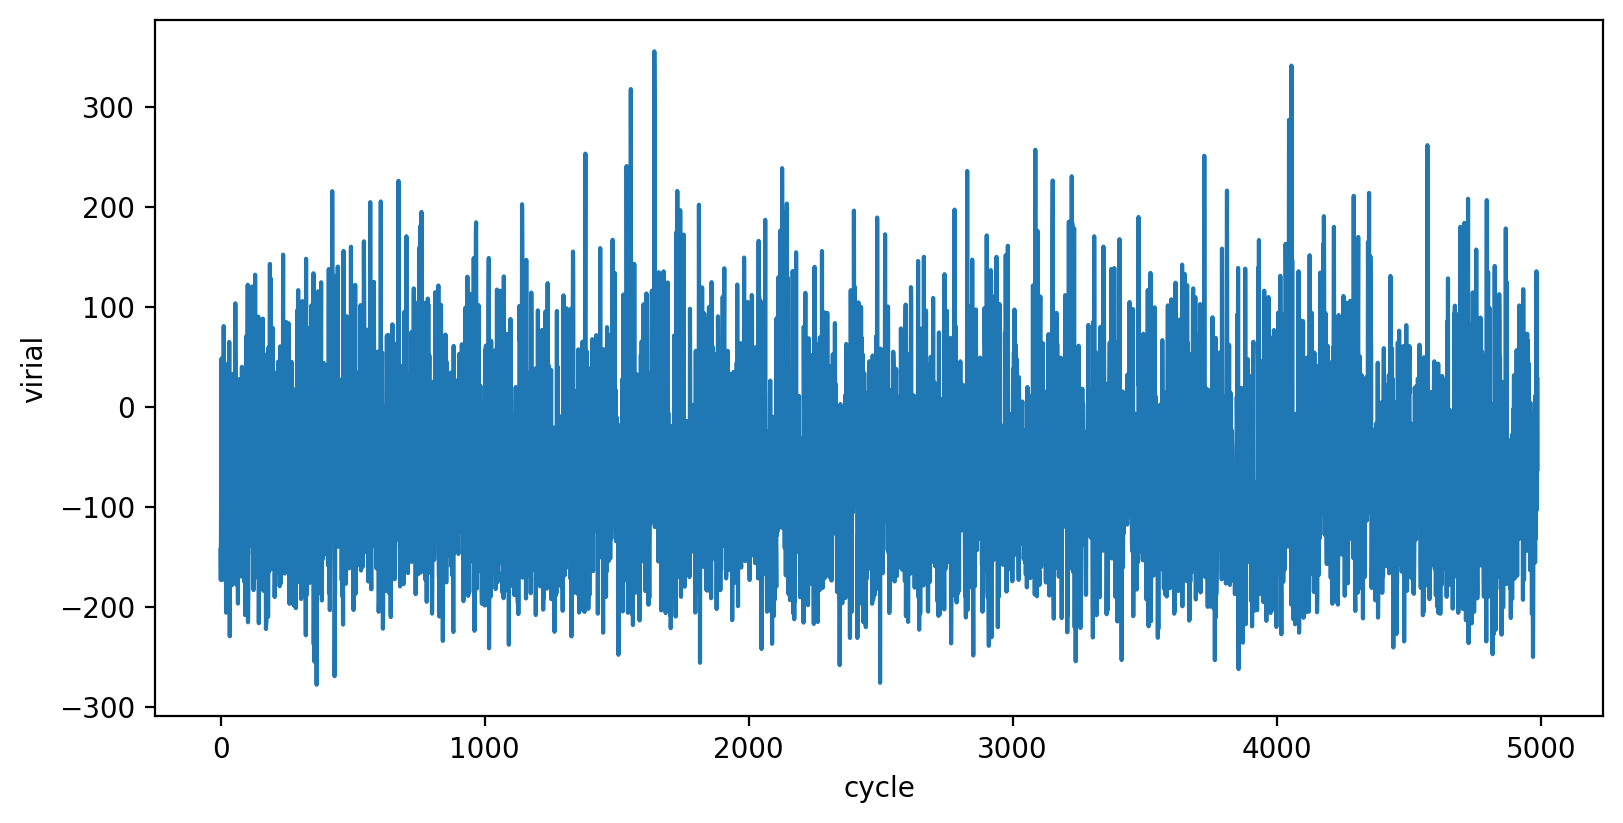

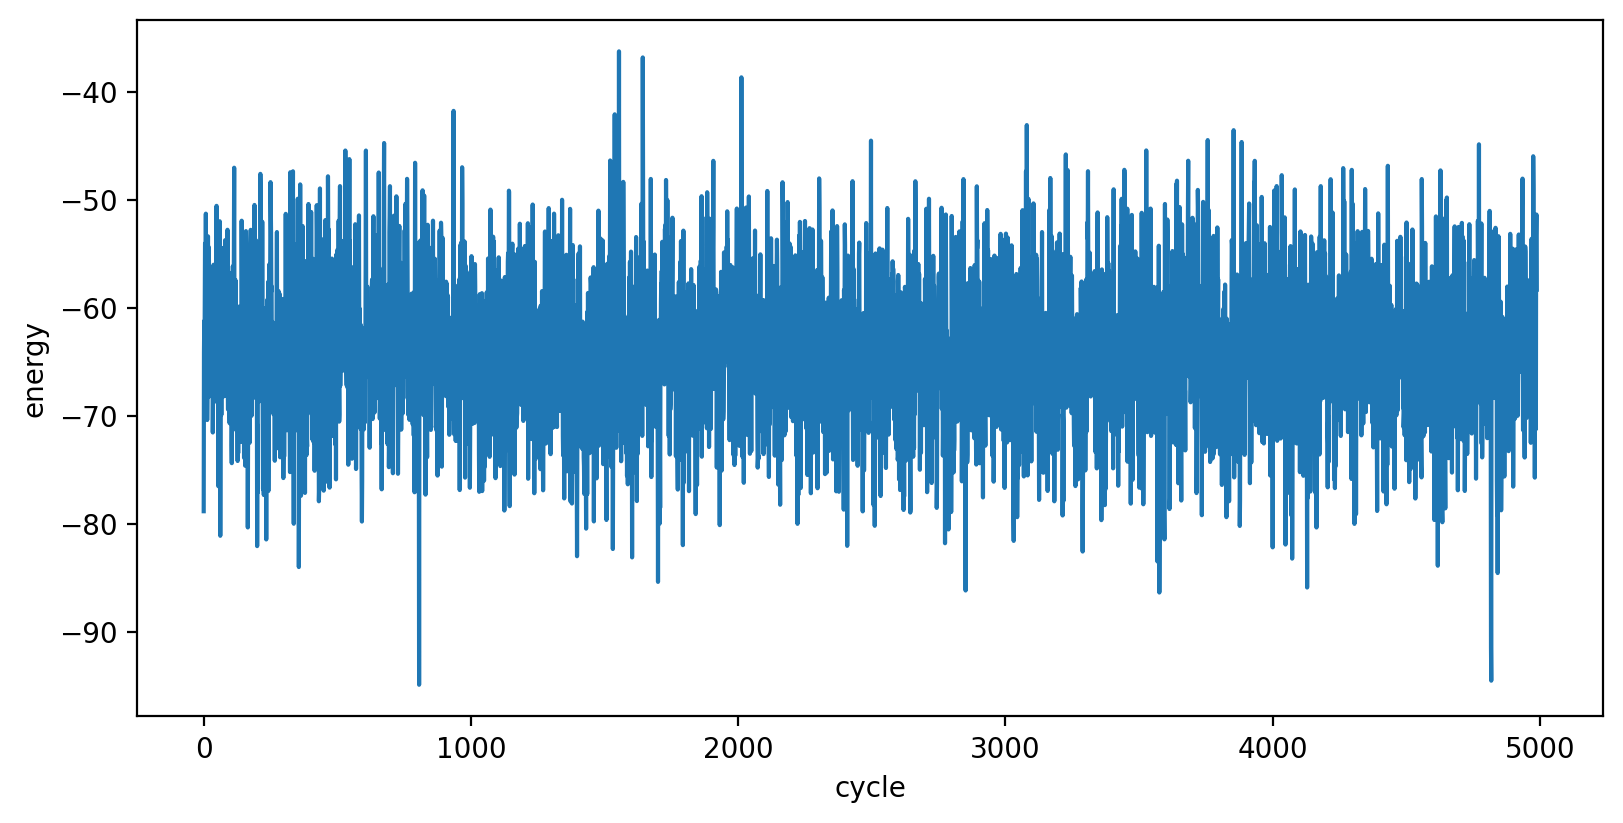

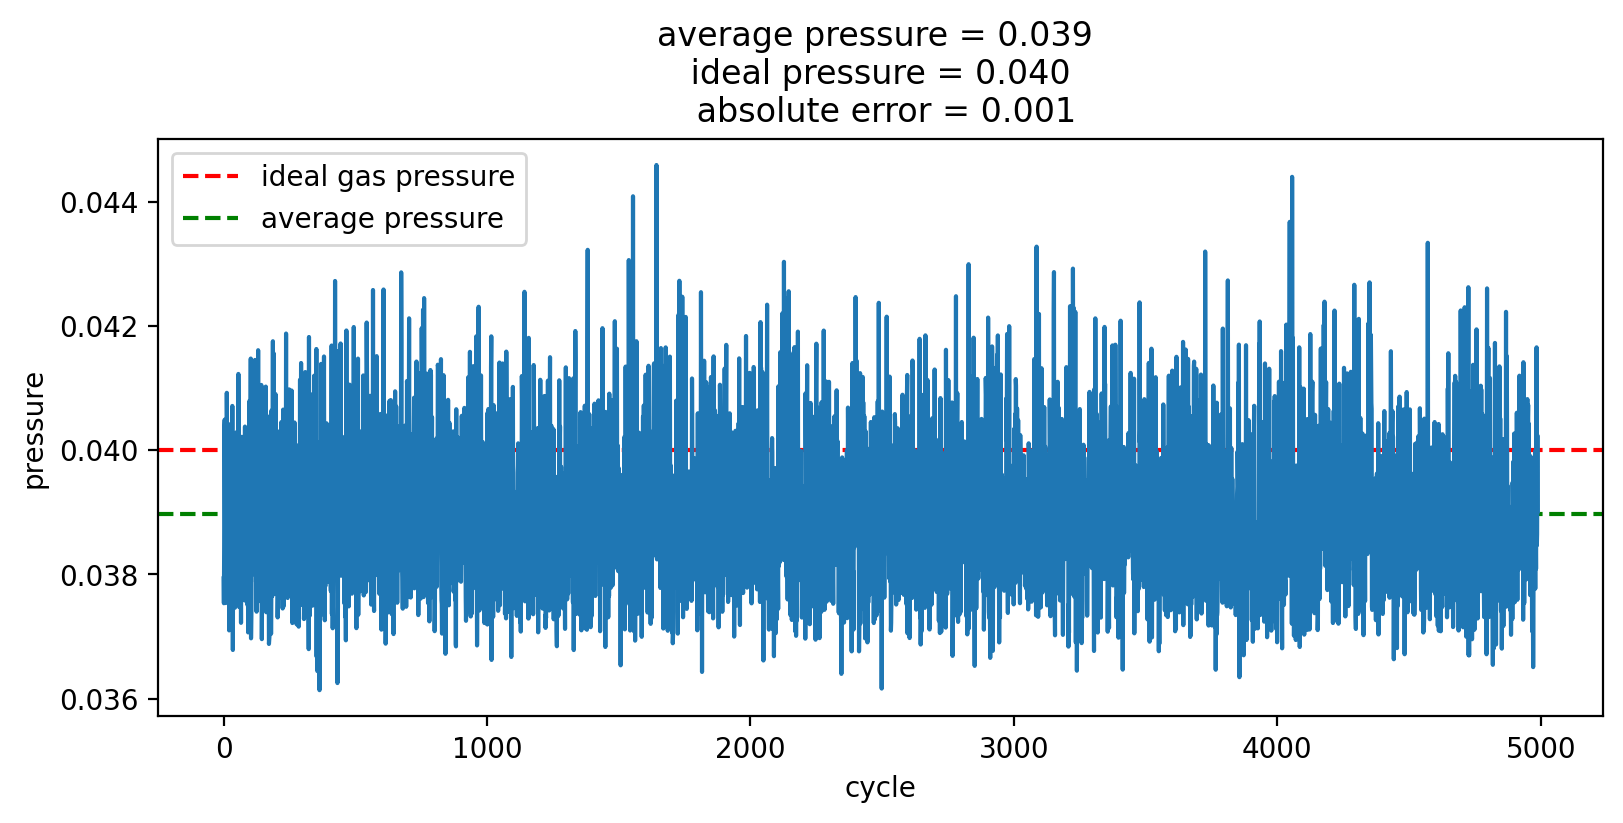

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200


def main():
    """
    Analyse a Lennard-Jones NVE MD trajectory.
    
    Reads data from "mc_simulation_data.pkl"
    """
    # load the data
    temperature = 2.0
    density = 0.02
    
    with open(f"mc_simulation_data_T{temperature}_density{density}.pkl", 'rb') as p:
        samples = pickle.load(p)

    # do some analysis

    fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
    virial = np.array([sample["virial"] for sample in samples])
    ax.plot(virial)
    ax.set_xlabel("cycle")
    ax.set_ylabel("virial")

    # plot the energy 
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
    energy = np.array([sample["energy"] for sample in samples])
    ax.plot(energy)
    ax.set_xlabel("cycle")
    ax.set_ylabel("energy")

    # plot the pressure
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
    pressure = np.array([sample["pressure"] for sample in samples])

    # add ideal gas pressure line, density/beta
    beta = 1 / temperature
    ideal_pressure = density / beta
    ax.axhline(ideal_pressure, color='red', linestyle='--', label="ideal gas pressure")

    # add average pressure line
    average_pressure = np.mean(pressure)
    ax.axhline(average_pressure, color='green', linestyle='--', label="average pressure")
    ax.legend()
    # add title with pressure absolute error
    ax.set_title(f"average pressure = {average_pressure:.3f} \n ideal pressure = {ideal_pressure:.3f} \n absolute error = {abs(average_pressure - ideal_pressure):.3f}")

    ax.plot(pressure)
    ax.set_xlabel("cycle")
    ax.set_ylabel("pressure")


if __name__=="__main__":
    main()

# Questions3, heat capacity

In [38]:
# 
temperature = 4.0
density = 0.1

with open(f"mc_simulation_data_T{temperature}_density{density}.pkl", 'rb') as p:
    samples = pickle.load(p)

energy = np.array([sample["energy"] for sample in samples])
cv = np.var(energy) / (temperature ** 2)/500
print(f"cv = {cv}")

cv = 0.04197066083822559
